# PUMA Dataset Sampling
Devise a method to pull sample from the PUMS dataset that is proportional (temporally) to respondents of the CMAP Survey.

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame
from shapely import Point
from pathlib import Path

epsg = "EPSG:4326"
data_folder = Path("../synth-survey-gen/data")

pums_person = pd.read_csv(data_folder / "MyDailyTravelData/person.csv", low_memory=False)
pums_location = pd.read_csv(data_folder / "MyDailyTravelData/location.csv")

puma_gdf = gpd.read_file(data_folder / "puma/ipums_puma_2010.shp")
puma_gdf = puma_gdf.to_crs(epsg)

Get GeoDataFrame of household locations and the number of people in that household.

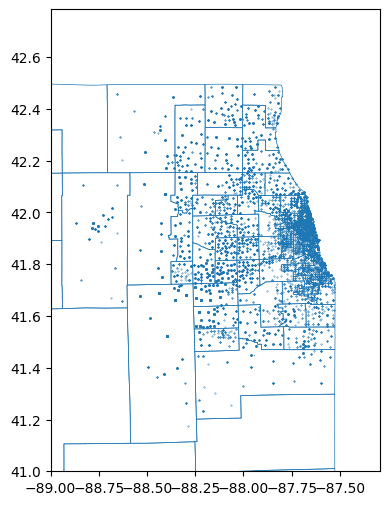

In [4]:
# get number of people in each household based on "sampno" the household identifier
household_size = pums_person[["sampno", "perno"]].groupby(by="sampno")["perno"].max()

# get location of each household as GeoDataFrame
household_locations = pums_location[pums_location.loctype==1] \
    .drop_duplicates(subset="sampno") \
    .set_index("sampno")[["latitude", "longitude"]]
household_locations = household_locations.join(household_size)
geometry = household_locations.apply(
    lambda row: Point(row.longitude, row.latitude), axis=1
    )
household_gdf = GeoDataFrame(household_locations, geometry=geometry, crs=epsg)

fig, ax = plt.subplots(figsize=(6,6), dpi=100)
puma_gdf[puma_gdf.State=="Illinois"].boundary.plot(ax=ax, linewidth=0.5)
household_gdf.plot(markersize=0.1, ax=ax, marker="o")
plt.ylim(bottom = 41.00)
plt.xlim(left = -89.00)
plt.show()
# plt.plot()

Spatial join PUMA areas to household locations


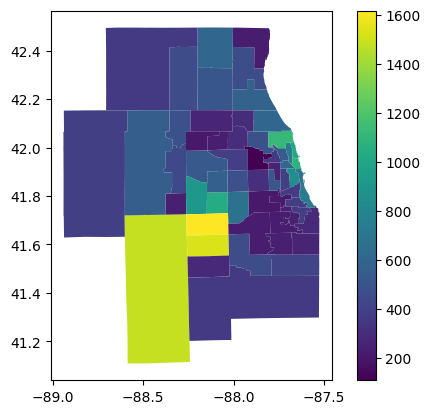

In [ ]:
# get count of households in each PUMA zone
household_join = household_gdf.sjoin(puma_gdf, predicate="within")
household_puma_counts = household_join.groupby(by=["PUMA"])["perno"].sum()

# join household counts to puma_gdf
puma_gdf_il = puma_gdf[puma_gdf.State=="Illinois"]
puma_household_counts = puma_gdf_il.set_index("PUMA").join(household_puma_counts, how = "inner")[["GEOID", "Name", "perno", "geometry"]]

puma_household_counts.plot(column="perno", legend=True)
plt.show()

Get household to puma and puma to perno

In [106]:
puma_perno_map = puma_household_counts.reset_index()[["PUMA", "perno"]]
sampno_puma_map = household_join.reset_index()[["sampno", "PUMA"]]

In [107]:
sampno_puma_map.merge(puma_perno_map, how="left", suffixes=("_l", "_r"), on="PUMA")

,sampno,PUMA,perno
0,20000083,03415,293
1,20000136,03525,665
2,20000228,03528,378
3,20000248,03501,1001
4,20000300,03525,665
...,...,...,...
12373,70100991,03413,259
12374,70100992,03310,583
12375,70100993,03523,391
12376,70100998,03523,391
